In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as process_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as process_vgg19
from tensorflow.keras.applications.resnet50 import preprocess_input as process_resnet
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *

import cv2
import random
import itertools
import os

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### UTILITY VARIABLES ###

base_path = "../input/split-garbage-dataset/split-garbage-dataset/"
labels = os.listdir(base_path + "train/")
SHAPE = (224,224,3)

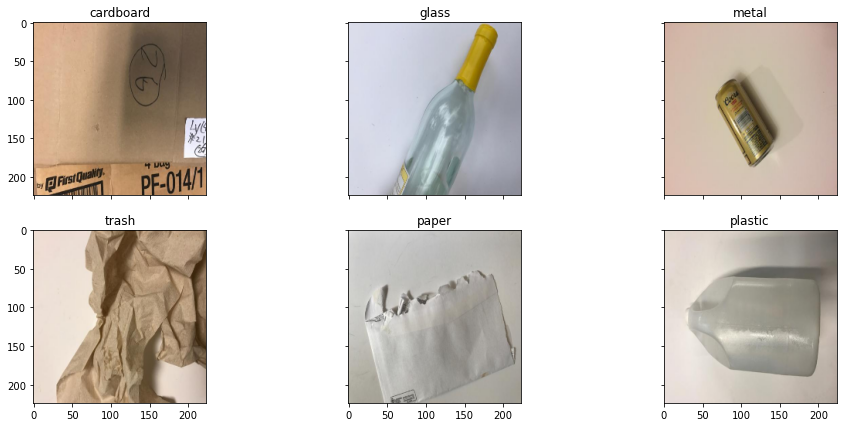

In [4]:
### PLOT IMAGES FROM EACH CLASS ###

f, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize = (16,7))

for ax, label in zip(axes.ravel(), labels):
    img = np.random.choice(os.listdir(base_path + "train/" + label))
    img = cv2.imread(base_path + "train/" + label + "/" + img)
    img = cv2.resize(img, SHAPE[:2])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGB))
    ax.set_title(label)

In [5]:
### INITILIZE GENERATOR ###

train_datagen = ImageDataGenerator(
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'
)

validation_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

In [6]:
### FIT GENERATOR ###

train_batch_size = 32
val_batch_size = 32

train_generator = train_datagen.flow_from_directory(
            base_path + '/train',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = train_batch_size,
            class_mode = 'categorical',
            shuffle = True
)

validation_generator = validation_datagen.flow_from_directory(
            base_path + '/valid',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle = False
)

test_generator = test_datagen.flow_from_directory(
            base_path + '/test',
            target_size = (SHAPE[0], SHAPE[1]),
            batch_size = val_batch_size,
            class_mode = 'categorical',
            shuffle = False
)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


In [7]:
### READ TEST DATA (USEFUL TO GET TEST LABEL FOR CUSTOM EVALUATION) ###

test_num = test_generator.samples

label_test = []
for i in range((test_num // test_generator.batch_size)+1):
    X,y = test_generator.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)

label_test.shape

(431,)

In [8]:
### UTILITY FUNCTION TO LOAD BASE MODELS ###

def import_base_model(SHAPE):

    vgg16 = VGG16(weights = 'imagenet', include_top = False, input_shape = SHAPE)
    vgg19 = VGG19(weights = 'imagenet', include_top = False, input_shape = SHAPE)
    resnet = ResNet50(weights = 'imagenet', include_top = False, input_shape = SHAPE)

    for layer in vgg16.layers[:-4]:
        layer.trainable = False

    for layer in vgg19.layers[:-5]:
        layer.trainable = False

    for layer in resnet.layers[:-10]:
        layer.trainable = False
        
    return vgg16, vgg19, resnet

# CONCATENATION

In [9]:
### LOAD BASE MODELS ###

vgg16, vgg19, resnet = import_base_model(SHAPE)

94773248/94765736 [==============================] - 2s 0us/step


In [10]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



inp = Input((224,224,3))

vgg_16_process = Lambda(process_vgg16)(inp)
vgg_16 = vgg16(vgg_16_process)
x_vgg_16 = GlobalMaxPool2D()(vgg_16)
x_vgg_16 = Dense(128, activation='relu')(x_vgg_16)

resnet_process = Lambda(process_resnet)(inp)
res_net = resnet(resnet_process)
x_resnet = GlobalMaxPool2D()(res_net)
x_resnet = Dense(128, activation='relu')(x_resnet)

vgg_19_process = Lambda(process_vgg19)(inp)
vgg_19 = vgg19(vgg_19_process)
x_vgg_19 = GlobalMaxPool2D()(vgg_19)
x_vgg_19 = Dense(128, activation='relu')(x_vgg_19)

x = Concatenate()([x_vgg_16, x_resnet, x_vgg_19])
out = Dense(6, activation='softmax')(x)

model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics='accuracy')

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
model.fit(train_generator, steps_per_epoch = train_generator.samples/train_generator.batch_size,
          epochs=50, validation_data=validation_generator, validation_steps = validation_generator.samples/validation_generator.batch_size, 
          callbacks=[es], verbose = 1)

Epoch 1/50
56/55 [==============================] - 44s 784ms/step - loss: 3.8453 - accuracy: 0.5809 - val_loss: 1.0433 - val_accuracy: 0.7591
Epoch 2/50
56/55 [==============================] - 41s 729ms/step - loss: 0.6857 - accuracy: 0.8162 - val_loss: 0.6441 - val_accuracy: 0.8323
Epoch 3/50
56/55 [==============================] - 40s 716ms/step - loss: 0.5555 - accuracy: 0.8411 - val_loss: 0.5514 - val_accuracy: 0.8384
Epoch 4/50
56/55 [==============================] - 40s 720ms/step - loss: 0.3063 - accuracy: 0.9005 - val_loss: 0.4255 - val_accuracy: 0.8811
Epoch 5/50
56/55 [==============================] - 40s 709ms/step - loss: 0.2561 - accuracy: 0.9259 - val_loss: 0.4129 - val_accuracy: 0.8902
Epoch 6/50
56/55 [==============================] - 40s 713ms/step - loss: 0.1825 - accuracy: 0.9378 - val_loss: 0.5394 - val_accuracy: 0.8598
Epoch 7/50
56/55 [==============================] - 39s 704ms/step - loss: 0.1929 - accuracy: 0.9417 - val_loss: 0.4680 - val_accuracy: 0.8689

In [11]:
### TEST PREDICTIONS ###

pred_test = np.argmax(model.predict(test_generator), axis=1)

In [12]:
print(classification_report(label_test, pred_test, target_names=labels))

              precision    recall  f1-score   support

   cardboard       0.97      0.90      0.93        70
       glass       0.86      0.93      0.89        82
       metal       0.86      0.97      0.91        68
       trash       0.89      0.93      0.91       108
       paper       0.93      0.74      0.83        74
     plastic       0.83      0.86      0.85        29

    accuracy                           0.89       431
   macro avg       0.89      0.89      0.89       431
weighted avg       0.90      0.89      0.89       431



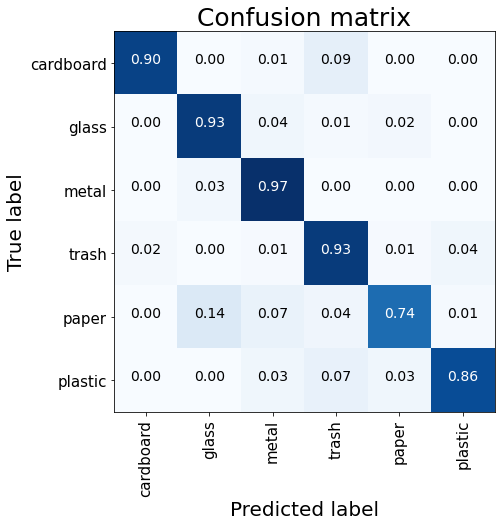

In [13]:
cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=labels)
plt.show()

# SIMPLE AVERAGE

In [14]:
### LOAD BASE MODELS ###

vgg16, vgg19, resnet = import_base_model(SHAPE)

In [15]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



inp = Input((224,224,3))

vgg_16_process = Lambda(process_vgg16)(inp)
vgg_16 = vgg16(vgg_16_process)
x_vgg_16 = GlobalMaxPool2D()(vgg_16)
x_vgg_16 = Dense(128, activation='relu')(x_vgg_16)

resnet_process = Lambda(process_resnet)(inp)
res_net = resnet(resnet_process)
x_resnet = GlobalMaxPool2D()(res_net)
x_resnet = Dense(128, activation='relu')(x_resnet)

vgg_19_process = Lambda(process_vgg19)(inp)
vgg_19 = vgg19(vgg_19_process)
x_vgg_19 = GlobalMaxPool2D()(vgg_19)
x_vgg_19 = Dense(128, activation='relu')(x_vgg_19)

x = Average()([x_vgg_16, x_resnet, x_vgg_19])
out = Dense(6, activation='softmax')(x)

model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics='accuracy')

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
model.fit(train_generator, steps_per_epoch = train_generator.samples/train_generator.batch_size,
          epochs=50, validation_data=validation_generator, validation_steps = validation_generator.samples/validation_generator.batch_size, 
          callbacks=[es], verbose = 1)

Epoch 1/50
56/55 [==============================] - 41s 729ms/step - loss: 2.4951 - accuracy: 0.6092 - val_loss: 0.6299 - val_accuracy: 0.7927
Epoch 2/50
56/55 [==============================] - 40s 711ms/step - loss: 0.5380 - accuracy: 0.8298 - val_loss: 0.6578 - val_accuracy: 0.8140
Epoch 3/50
56/55 [==============================] - 39s 704ms/step - loss: 0.3785 - accuracy: 0.8761 - val_loss: 0.4839 - val_accuracy: 0.8628
Epoch 4/50
56/55 [==============================] - 38s 685ms/step - loss: 0.3087 - accuracy: 0.8982 - val_loss: 0.5103 - val_accuracy: 0.8537
Epoch 5/50
56/55 [==============================] - 39s 705ms/step - loss: 0.2077 - accuracy: 0.9372 - val_loss: 0.3735 - val_accuracy: 0.8994
Epoch 6/50
56/55 [==============================] - 39s 700ms/step - loss: 0.1540 - accuracy: 0.9463 - val_loss: 0.3867 - val_accuracy: 0.8841
Epoch 7/50
56/55 [==============================] - 39s 704ms/step - loss: 0.1319 - accuracy: 0.9542 - val_loss: 0.3809 - val_accuracy: 0.8872

In [16]:
### TEST PREDICTIONS ###

pred_test = np.argmax(model.predict(test_generator), axis=1)

In [17]:
print(classification_report(label_test, pred_test, target_names=labels))

              precision    recall  f1-score   support

   cardboard       0.98      0.90      0.94        70
       glass       0.89      0.93      0.91        82
       metal       0.89      0.87      0.88        68
       trash       0.87      0.95      0.91       108
       paper       0.85      0.84      0.84        74
     plastic       0.88      0.76      0.81        29

    accuracy                           0.89       431
   macro avg       0.90      0.87      0.88       431
weighted avg       0.89      0.89      0.89       431



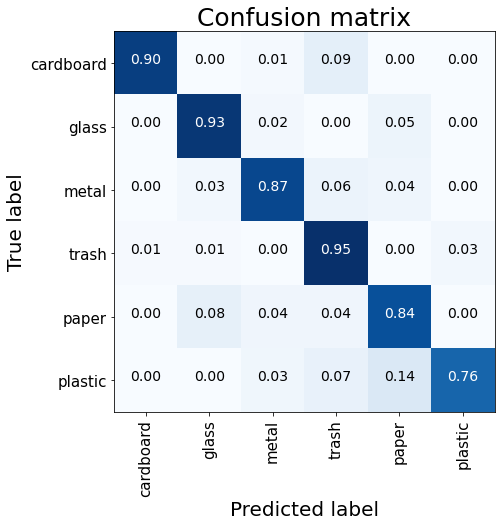

In [18]:
cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=labels)
plt.show()

# WEIGHTED AVERAGE

In [19]:
### LOAD BASE MODELS ###

vgg16, vgg19, resnet = import_base_model(SHAPE)

In [20]:
### CUSTOM LAYER FOR WEIGHTED LERNABLE ENSEMBLE ###

class linear_W(Layer):

    def __init__(self, n_output):
        super(linear_W, self).__init__()
        self.W = tf.Variable(initial_value=tf.random.uniform(shape=[1,1,n_output], minval=0, maxval=1),
            trainable=True) # (1,1,n_inputs)

    def call(self, inputs):

        # inputs is a list of tensor of shape [(n_batch, n_feat), ..., (n_batch, n_feat)]
        # expand last dim of each input passed [(n_batch, n_feat, 1), ..., (n_batch, n_feat, 1)]
        inputs = [tf.expand_dims(i, -1) for i in inputs]
        inputs = Concatenate(axis=-1)(inputs) # (n_batch, n_feat, n_inputs)
        weights = tf.nn.softmax(self.W, axis=-1) # (1,1,n_inputs)
        # weights sum up to one on last dim

        return tf.reduce_sum(weights*inputs, axis=-1) # (n_batch, n_feat)

In [21]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



inp = Input((224,224,3))

vgg_16_process = Lambda(process_vgg16)(inp)
vgg_16 = vgg16(vgg_16_process)
x_vgg_16 = GlobalMaxPool2D()(vgg_16)
x_vgg_16 = Dense(128, activation='relu')(x_vgg_16)

resnet_process = Lambda(process_resnet)(inp)
res_net = resnet(resnet_process)
x_resnet = GlobalMaxPool2D()(res_net)
x_resnet = Dense(128, activation='relu')(x_resnet)

vgg_19_process = Lambda(process_vgg19)(inp)
vgg_19 = vgg19(vgg_19_process)
x_vgg_19 = GlobalMaxPool2D()(vgg_19)
x_vgg_19 = Dense(128, activation='relu')(x_vgg_19)

partial_output = [x_vgg_16, x_resnet, x_vgg_19]
x = linear_W(n_output=len(partial_output))(partial_output)
out = Dense(6, activation='softmax')(x)

model = Model(inp, out)
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics='accuracy')

es = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
model.fit(train_generator, steps_per_epoch = train_generator.samples/train_generator.batch_size,
          epochs=50, validation_data=validation_generator, validation_steps = validation_generator.samples/validation_generator.batch_size, 
          callbacks=[es], verbose = 1)

Epoch 1/50
56/55 [==============================] - 41s 733ms/step - loss: 2.6273 - accuracy: 0.5979 - val_loss: 0.9284 - val_accuracy: 0.7500
Epoch 2/50
56/55 [==============================] - 40s 721ms/step - loss: 0.5641 - accuracy: 0.8275 - val_loss: 0.7352 - val_accuracy: 0.7744
Epoch 3/50
56/55 [==============================] - 41s 724ms/step - loss: 0.3686 - accuracy: 0.8744 - val_loss: 0.5573 - val_accuracy: 0.8201
Epoch 4/50
56/55 [==============================] - 40s 711ms/step - loss: 0.3029 - accuracy: 0.9067 - val_loss: 0.4119 - val_accuracy: 0.8780
Epoch 5/50
56/55 [==============================] - 40s 708ms/step - loss: 0.2332 - accuracy: 0.9152 - val_loss: 0.4571 - val_accuracy: 0.8720
Epoch 6/50
56/55 [==============================] - 40s 723ms/step - loss: 0.1694 - accuracy: 0.9417 - val_loss: 0.4284 - val_accuracy: 0.8750
Epoch 7/50
56/55 [==============================] - 39s 705ms/step - loss: 0.1302 - accuracy: 0.9576 - val_loss: 0.4275 - val_accuracy: 0.8750

In [22]:
### EXTRACT LEARNED WEIGTHS OF EACH BASE MODEL ###

tf.nn.softmax(model.get_weights()[-3]).numpy()

array([[[0.4318038 , 0.21031192, 0.3578843 ]]], dtype=float32)

In [23]:
### TEST PREDICTIONS ###

pred_test = np.argmax(model.predict(test_generator), axis=1)

In [24]:
print(classification_report(label_test, pred_test, target_names=labels))

              precision    recall  f1-score   support

   cardboard       1.00      0.90      0.95        70
       glass       0.96      0.88      0.92        82
       metal       0.88      0.96      0.92        68
       trash       0.89      0.97      0.93       108
       paper       0.89      0.91      0.90        74
     plastic       0.85      0.76      0.80        29

    accuracy                           0.91       431
   macro avg       0.91      0.90      0.90       431
weighted avg       0.92      0.91      0.91       431



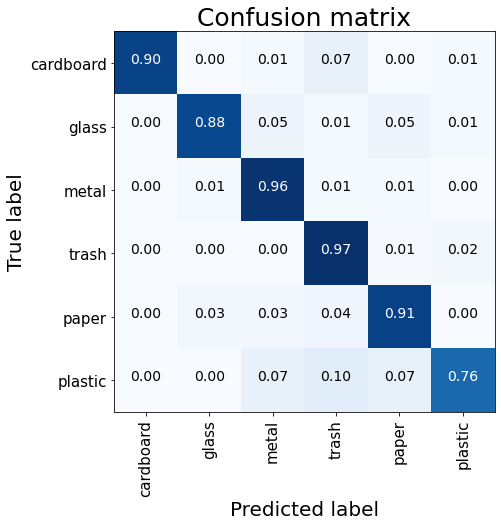

In [25]:
cnf_matrix = confusion_matrix(label_test, pred_test)

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=labels)
plt.show()